### **Librerías**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
import pprint as pp
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from constants import DATA_DIR
from utils.plots import plot_time_series

from IPython.display import clear_output
from statsmodels.tsa.arima_process import arma_generate_sample

np.random.seed(13)

### **Columnas para los DataFrames**

In [3]:
COLUMNS = ['sim', 'id', 'inicio_prog', 't', 'y', 'y_cf', 'tratado', 'control']

### **Directorio base de los datos**

In [4]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
else:
    print(f"The directory {DATA_DIR} already exists")

The directory /users/bbas/TrabajoFinal/data/Benja already exists


### **Número de grupo**

In [5]:
# Get the number of the last group generated
# groups_dirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
# pattern = r'Grupo(\d+)'

# numbers = []
# for dir in groups_dirs:
#     match = re.search(pattern, dir)
#     if match:
#         numbers.append(int(match.group(1)))

# if numbers:
#     group_number = max(numbers) + 1
#     print(f"The new group number is: {group_number}")
# else:
#     print("No folders with the pattern 'GrupoN' found. Setting it to 1...")
#     group_number = 1

group_number = 5

GROUP_PATH = os.path.join(DATA_DIR, f"Grupo{group_number}")
if os.path.exists(GROUP_PATH):
    raise Exception(f"{GROUP_PATH} already exists")

print(f"Creating the group directory: {GROUP_PATH}")
os.makedirs(GROUP_PATH)

Creating the group directory: /users/bbas/TrabajoFinal/data/Benja/Grupo5


### **Parámetros**
Para más información sobre qué representa cada parámetro, leer el archivo `README.md` de este directorio.

#### **Parámetros fijos**

In [6]:
ini = 200
StdErrorSerie = 5

#### **Cargamos parámetros variables**

In [7]:
PARAMS_PATH = os.path.join(os.getcwd(), 'params.json')
with open(PARAMS_PATH, 'r') as f:
    params = json.load(f)

n_simulations = params['n_simulations']

n_total = params['n_total']
n_treated = params['n_treated']
n_control = params['n_control']
n_nini = n_total - (n_treated + n_control)

T = params['T']
total_periods = T + ini
first_tr_period = params['first_tr_period']

n_cohorts = params['n_cohorts']
n_per_dep = params['n_per_dep']

ups_max_count = params['ups_max_count']

if n_per_dep > first_tr_period:
    raise Exception(
        "The number of depending periods is greater than the first treatment period."
        "Please correct it."
    )

# phi: autorregresive component. T: Treated, C: Control, N: NiNis.
phiT = params['phiT']
phiC = params['phiC']
phiNiNi = params['phiNiNi']

# FE: Fixed Effects. T: Treated, C: Control, N: NiNis.
MeanFET = params['MeanFET']
MeanFEC = params['MeanFEC']
MeanFEN = params['MeanFEN']

pp.pp(params)

{'n_simulations': 100,
 'n_total': 10000,
 'n_treated': 1000,
 'n_control': 1000,
 'T': 50,
 'first_tr_period': 46,
 'n_cohorts': 3,
 'n_per_dep': 5,
 'ups_max_count': 0,
 'phiT': 0.9,
 'phiC': 0.9,
 'phiNiNi': 0.9,
 'MeanFET': 10.0,
 'MeanFEC': 10.0,
 'MeanFEN': 10.0}


In [8]:
####### Parámetros relacionados al impacto
phiTra = 0.90
ImpactoProporcional = 0.05
ImpactoNominal = MeanFEC * ImpactoProporcional
STDImpacto = 0.05

hetecohorte = 1

Escribimos los parámetros usados a la carpeta del nuevo grupo.

In [9]:
params["group_number"] = group_number

group_params_path = os.path.join(GROUP_PATH, f"params_Grupo{group_number}.json")
with open(group_params_path, "w") as f:
    json.dump(params, f, indent=4)

In [10]:
def gen_next_time_step(base_mean, phi, previous, std_error):
    return (
        (1 - phi) * base_mean + phi * previous + np.random.normal(0, 1) * std_error
    )

def gen_time_series_with_trend(
    steps,
    n_per_dep,
    mean_fixed_effects,
    std_error,
    fixed_effect_i,
    mean_temp_effects,
    phi,
    treatment_start,
    ups_max_count
):
    y = np.zeros(steps)

    base_mean = mean_fixed_effects + fixed_effect_i + mean_temp_effects
    y[0] = base_mean + np.random.normal(0, 1) * std_error

    trend_start = treatment_start - n_per_dep
    trend_end   = treatment_start - 1

    ups_count = 0
    for t in range(1, steps):
        next_value = gen_next_time_step(base_mean, phi, y[t - 1], std_error)
        if trend_start <= t <= trend_end:
            if next_value > y[t-1] and ups_count < ups_max_count:
                ups_count += 1
            else:
                while next_value >= y[t-1]:
                    next_value = gen_next_time_step(base_mean, phi, y[t - 1], std_error)
        y[t] = next_value

    return y

In [11]:
for sim in range(n_simulations):
    print(f"Simulación {sim+1} de {n_simulations}")

    YPanelTreated = np.zeros(shape=(n_treated*T, len(COLUMNS)))
    YPanelControl = np.zeros(shape=(n_control*T, len(COLUMNS)))
    YPanelNiNi = np.zeros(shape=(n_nini*T, len(COLUMNS)))

    # A time effect, one for each time step
    TE = np.random.normal(0,1,T+ini)
    MeanTE = TE.mean()

    y_treated = np.zeros(shape=(n_treated, T))
    y_control = np.zeros(shape=(n_control, T))
    y_nini = np.zeros(shape=(n_nini, T))
    tr_starts_indexes = []

    # Amount of treated units per cohort
    if n_treated % n_cohorts == 0:
        n_treated_in_cohort = int(n_treated / n_cohorts)
    else:
        n_treated_in_cohort = int(n_treated / n_cohorts) + (n_treated % n_cohorts)

    for dataset, label in [(y_treated, 'Tratados'), (y_control, 'Controles')]:
        print(f"\tGenerando datos para {label}...")
        # A fixed effect for each unit
        EfectoFijoT = np.random.normal(0, 1, len(dataset)) + MeanFET
        for cohort in range(n_cohorts):
            # Subtract 1 to turn it 0-indexed
            tr_start_index = (ini + first_tr_period + cohort) - 1
            print(
                f"\t\tCohorte {cohort+1} de {n_cohorts}: "
                f"inicio de programa en {tr_start_index+1-ini}."
            )
            for i in range(n_treated_in_cohort):
                y_i = gen_time_series_with_trend(
                    total_periods, n_per_dep, MeanFET, StdErrorSerie, EfectoFijoT[i],
                    MeanTE, phiT, tr_start_index, ups_max_count
                )
                tr_starts_indexes.append(tr_start_index-ini)
                index = (cohort*n_treated_in_cohort) + i
                if index < len(dataset):
                    dataset[index, :] = y_i[ini:]
        print()

    y_counterfac = y_treated.copy()

    # Apply treatment only to the treated units
    for i in range(n_treated):
        tr_start_index = tr_starts_indexes[i]
        tr_length = T - tr_start_index
        if hetecohorte == 1:
            arparams = np.array([phiTra, 0])
            maparams = np.array([0, 0])
            arparams = np.r_[1, -arparams]
            maparams = np.r_[1, maparams]
            impact = arma_generate_sample(
                arparams, maparams, tr_length, burnin=5000
            ) + ImpactoNominal
            y_treated[i, tr_start_index:] += impact
        else:
            TraCondicion = np.array(tr_starts_indexes)
            y_treated[i, tr_start_index:] += np.random.normal(
                ImpactoNominal, STDImpacto, tr_length
            )
            TraCondicion = np.array(tr_starts_indexes)

    # Reshape the data from horizontal to vertical format with extra columns
    for panel, dataset, label in [
        (YPanelTreated, y_treated, 'Tratados'),
        (YPanelControl, y_control, 'Controles')
    ]:
        print(f"\tCambiando formato de datos para {label}...")
        n = len(dataset)
        panel[:, 0] = sim + 1
        panel[:, 6] = int(label == 'Tratados')
        panel[:, 7] = int(label == 'Controles')

        ids = np.zeros((n*T, 1))
        tr_starts = np.zeros((n*T, 1))
        steps = np.zeros((n*T, 1))
        y = np.zeros((n*T, 1))
        y_cf = np.zeros((n*T, 1))
        for i in range(n):
            ids[(i*T):((i+1)*T)] = i if label == 'Tratados' else i + n_treated
            tr_starts[(i*T):((i+1)*T)] = tr_starts_indexes[i]
            steps[(i*T):((i+1)*T)] = np.arange(T).reshape(T, 1)
            y[(i*T):((i+1)*T)] = np.reshape(dataset[i,:], (T, 1))
            y_cf[(i*T):((i+1)*T)] = (
                np.reshape(y_counterfac[i,:], (T, 1)) if label == 'Tratados' else 0
            )

        panel[:, 1] = np.reshape(ids, (n*T,))
        panel[:, 2] = np.reshape(tr_starts, (n*T,))
        panel[:, 3] = np.reshape(steps, (n*T,))
        panel[:, 4] = np.reshape(y, (n*T,))
        panel[:, 5] = np.reshape(y_cf, (n*T,))

    # Generate the data for the nini group
    EfectoFijoNiNi = np.random.normal(0, 1, n_nini) + MeanFEN

    print(f"\tGenerando datos para NiNi...")
    for i in range(n_nini):
        y_i = np.zeros(total_periods)
        y_i[0] = (
            MeanFEN + EfectoFijoNiNi[i] + MeanTE + np.random.normal(0,1) * StdErrorSerie
        )
        for t in range(total_periods):
            y_i[t] = gen_next_time_step(
                MeanFEN + EfectoFijoNiNi[i] + MeanTE, phiNiNi, y_i[t-1], StdErrorSerie
            )
        y_nini[i,:] = y_i[ini:]

    # Reshape the data from horizontal to vertical format with extra columns
    print(f"\tCambiando formato de datos para NiNi...")
    n = n_nini
    YPanelNiNi[:, 0] = sim + 1

    ids = np.zeros((n*T, 1))
    steps = np.zeros((n*T, 1))
    y = np.zeros((n*T, 1))
    for i in range(n):
        ids[(i*T):((i+1)*T)] = i + (n_treated + n_control)
        steps[(i*T):((i+1)*T)] = np.arange(T).reshape(T, 1)
        y[(i*T):((i+1)*T)] = np.reshape(y_nini[i,:], (T, 1))

    YPanelNiNi[:, 1] = np.reshape(ids, (n*T,))
    YPanelNiNi[:, 3] = np.reshape(steps, (n*T,))
    YPanelNiNi[:, 4] = np.reshape(y, (n*T,))
    # Columns 2, 5, 6 and 7 are already filled with zeros

    print("\tGenerando DataFrames")
    df_treated = pd.DataFrame(YPanelTreated, columns=COLUMNS)
    df_control = pd.DataFrame(YPanelControl, columns=COLUMNS)
    df_nini = pd.DataFrame(YPanelNiNi, columns=COLUMNS)
    
    df = pd.concat([df_treated, df_control, df_nini])
    df['sim'] = df['sim'].astype(int)
    df['id'] = df['id'].astype(int)
    df['inicio_prog'] = df['inicio_prog'].astype(int)
    df['t'] = df['t'].astype(int)
    df['tratado'] = df['tratado'].astype(int)
    df['control'] = df['control'].astype(int)

    sim_path = os.path.join(GROUP_PATH, f"Simulacion{sim+1}.dta")
    df.to_stata(sim_path, write_index=False)
    clear_output(wait=True)

Simulación 100 de 100
	Generando datos para Tratados...
		Cohorte 1 de 3: inicio de programa en 46.
		Cohorte 2 de 3: inicio de programa en 47.
		Cohorte 3 de 3: inicio de programa en 48.

	Generando datos para Controles...
		Cohorte 1 de 3: inicio de programa en 46.
		Cohorte 2 de 3: inicio de programa en 47.
		Cohorte 3 de 3: inicio de programa en 48.

	Cambiando formato de datos para Tratados...
	Cambiando formato de datos para Controles...
	Generando datos para NiNi...
	Cambiando formato de datos para NiNi...
	Generando DataFrames


In [ ]:
for sim in range(1, n_simulations+1):
    SIM_PATH = os.path.join(GROUP_PATH, f'Simulacion{sim}.dta')

    if not os.path.exists(SIM_PATH):
        print(f"The file {SIM_PATH} does not exist.")
    else:
        df = pd.read_stata(SIM_PATH)

    df_relevant_periods = df[df['t'] < 15]
    df_relevant_columns = df_relevant_periods.drop(columns=['sim', 'y_cf', 'inicio_prog'])
    df_wide = df_relevant_columns.pivot(index='id', columns='t', values='y')
    df_wide.columns = [f'y{col}' for col in df_wide.columns]
    df_wide = df_wide.reset_index()

    metadata = df[['id', 'tratado', 'control']].drop_duplicates()
    final_df = df_wide.merge(metadata, on='id')

    treated = final_df[final_df['tratado'] == 1]
    control = final_df[final_df['control'] == 1]
    nini = final_df[(final_df['tratado'] == 0) & (final_df['control'] == 0)]

    periods_columns = [f"y{i}" for i in range(0, 15)]
    treated_periods = treated[periods_columns]
    control_periods = control[periods_columns]
    nini_periods = nini[periods_columns]

    treated_means = treated_periods.mean().to_list()
    control_means = control_periods.mean().to_list()
    nini_means    = nini_periods.mean().to_list()

    for i in range(len(periods_columns)):
        assert(nini_means[i] < treated_means[i])
        assert(nini_means[i] < control_means[i])

In [ ]:
fig, ax = plot_time_series(treated_periods, 10, "Tratados" , 0, 'green')
fig, ax = plot_time_series(control_periods, 10, "Controles", 0, 'blue', ax)
fig, ax = plot_time_series(nini_periods,    10, "NiNi"     , 0, 'red' , ax)

ax.set_title(f"Individuos", fontsize=14, fontweight='bold', pad=20)

In [ ]:
t = list(range(1, 16))

plt.figure(figsize=(10, 6))
plt.plot(t, treated_means, color='blue', label='Tratados')
plt.plot(t, control_means, color='red', label='Controles')
plt.plot(t, nini_means, color='green', label='NiNi')
plt.xticks(t)
plt.grid()
plt.legend()
plt.show()

Como chequeo de sanidad sobre las simulaciones generadas, verificamos varias cosas:
* Que cada simulación tenga la cantidad total deseada de individuos (`n_total`)
* Que cada simulación tenga la cantidad total deseada de tratados (`n_treated`)
* Que cada simulación tenga la cantidad total deseada de controles (`n_control`)
* Que cada simulación tenga la cantidad total deseada de nini (`n_nini`)
* Que en los períodos relevantes (que van desde uno antes del inicio del programa
hasta el inicio del programa menos la cantiadad de períodos de dependencia):
  * Todos los valores de `y` hayan sido generados
  * Todos los valores de `y` sean distintos de cero
  * Tratados y controles tengan la tendencia creciente deseada
  * Los nini no tengan la tendencia creciente

Graficamos algunas series de tiempo para verificar la tendencia que esperamos

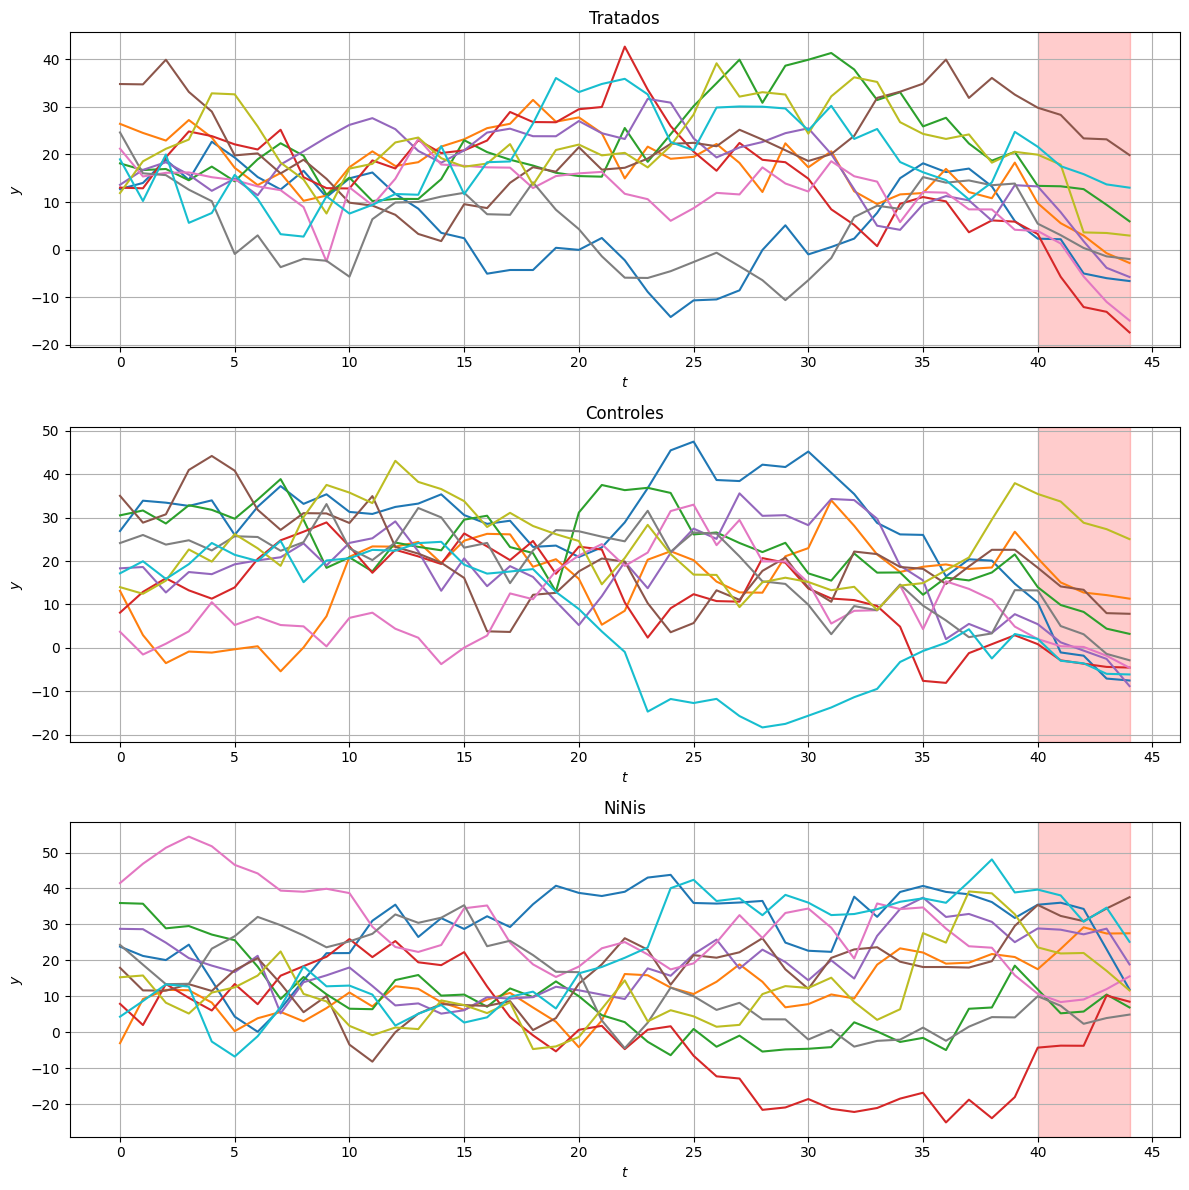

In [12]:
SIM_NUM = 1
SIM_PATH = os.path.join(GROUP_PATH, f'Simulacion{SIM_NUM}.dta')

if not os.path.exists(SIM_PATH):
    print(f"The file {SIM_PATH} does not exist.")
else:
    df = pd.read_stata(SIM_PATH)

    df_treated = df[df['tratado'] == 1]
    df_control = df[df['control'] == 1]
    df_nini = df[(df['tratado'] == 0) & (df['control'] == 0)]

    treated_ids = df_treated['id'].unique()
    control_ids = df_control['id'].unique()
    nini_ids = df_nini['id'].unique()

    # Check quantities
    assert(len(treated_ids)) == n_treated
    assert(len(control_ids)) == n_control
    assert(len(nini_ids)) == n_nini

    treated_ids_sample = np.random.choice(treated_ids, size=10, replace=False)
    control_ids_sample = np.random.choice(control_ids, size=10, replace=False)
    nini_ids_sample = np.random.choice(nini_ids, size=10, replace=False)

    treated_sample = df_treated[df_treated['id'].isin(treated_ids_sample)]
    control_sample = df_control[df_control['id'].isin(control_ids_sample)]
    nini_sample = df_nini[df_nini['id'].isin(nini_ids_sample)]

    fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=1)
    for i, df in enumerate([treated_sample, control_sample, nini_sample]):
        for _, data in df.groupby('id'):
            if df is nini_sample:
                tr_start_index = first_tr_period - 1
            else:
                tr_start_index = data['inicio_prog'].values[0]
            relevant_periods = data['t'].between(
                tr_start_index - (first_tr_period - 1), tr_start_index - 1
            )
            y = data['y'].to_numpy()[relevant_periods]
            assert(len(y) == first_tr_period - 1)
            ax[i].plot(y)
        ax[i].set_title(['Tratados', 'Controles', 'NiNis'][i])
        ax[i].set_xlabel('$t$')
        ax[i].set_ylabel('$y$')
        ax[i].grid(True)
        ax[i].axvspan(first_tr_period - n_per_dep - 1, first_tr_period - 2, color="red", alpha=0.2)
        ax[i].set_xticks(list(range(0, first_tr_period, 5)))
    plt.tight_layout()
    plt.show()